In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

from ese.experiment.analysis.analyze_inf import load_cal_inference_stats
# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_outputs" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [2]:
%%yaml results_cfg 

log:
    root: /storage/vbutoi/scratch/ESE/inference
    inference_groups: 
        - '06_12_24_WMH_FullMultiAnnoVol'

options:
    add_dice_loss_rows: True
    drop_nan_metric_rows: True 
    remove_shared_columns: False
    equal_rows_per_cfg_assert: False 

<IPython.core.display.Javascript object>

In [3]:
inference_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=True,
)

Finished loading inference stats.
Log amounts: root                                                                                             log_set                                              
/storage/vbutoi/scratch/ESE/inference/06_12_24_WMH_FullMultiAnnoVol/WMH_Individual_Uncalibrated  20240612_085239-WVBT-9dccca4ef8afec21bca192030f75d2f1    19795
                                                                                                 20240612_085243-02NK-1334ebc13752b362cdeef2fdd4b66604    19795
                                                                                                 20240612_085248-V8CE-b3a5b8910b19a1589e7e2ac95c5a1681    19795
                                                                                                 20240612_085252-LF35-09c30a291004abade2e995305a5e1c0e    19795
                                                                                                 20240612_085255-A64D-ee4f8a434727eec178bed49efca3de53    13282
  

In [4]:
# We use the following many subjects in our analysis.
print(inference_df.data_id.unique().shape[0])

38


In [5]:
# Next let's make our predictions into their corresponding volumes.
volume_df = inference_df.groupby([
    "annotator",
    "data_id",
    "pretrained_seed", 
    "task"
])[["gt_volume", "soft_volume", "hard_volume"]].sum().reset_index()

In [6]:
volume_df

,annotator,data_id,pretrained_seed,task,gt_volume,soft_volume,hard_volume
0,observer_o12,101,40,Amsterdam,44467,67689.760729,52222
1,observer_o12,101,41,Amsterdam,44467,58243.349105,42994
2,observer_o12,101,42,Amsterdam,44467,55679.956664,40917
3,observer_o12,101,43,Amsterdam,44467,70448.994057,51110
4,observer_o12,102,40,Amsterdam,61046,55479.210965,41607
...,...,...,...,...,...,...,...
251,observer_o4,66,43,Singapore,133887,155100.653450,134498
252,observer_o4,69,40,Singapore,183120,204427.736616,190229
253,observer_o4,69,41,Singapore,183120,206718.840726,190986
254,observer_o4,69,42,Singapore,183120,206365.886038,188224


In [7]:
# Make two new columns, one for the soft volume error and one for the hard volume error.
volume_df['soft_volume_error'] = volume_df['soft_volume'] - volume_df['gt_volume']
volume_df['hard_volume_error'] = volume_df['hard_volume'] - volume_df['gt_volume']

In [8]:
melted_error_df = pd.melt(
    volume_df,
    id_vars=["annotator", "data_id", "pretrained_seed", "task", "gt_volume", "soft_volume", "hard_volume"],
    value_vars=["soft_volume_error", "hard_volume_error"],
    var_name="volume_type",
    value_name="error",
)

In [9]:
import numpy as np

# Make some columns that are useful for plotting.
melted_error_df['abs_error'] = melted_error_df['error'].abs()
melted_error_df['log_abs_error'] = melted_error_df['error'].abs().apply(lambda x: np.log(x + 1))

# Experiment 1: Looking at one annotator on Amsterdam, let's look at how the volumetric comparison looks like.

In [10]:
exp_1_df = melted_error_df.select(annotator='observer_o12', task='Amsterdam')

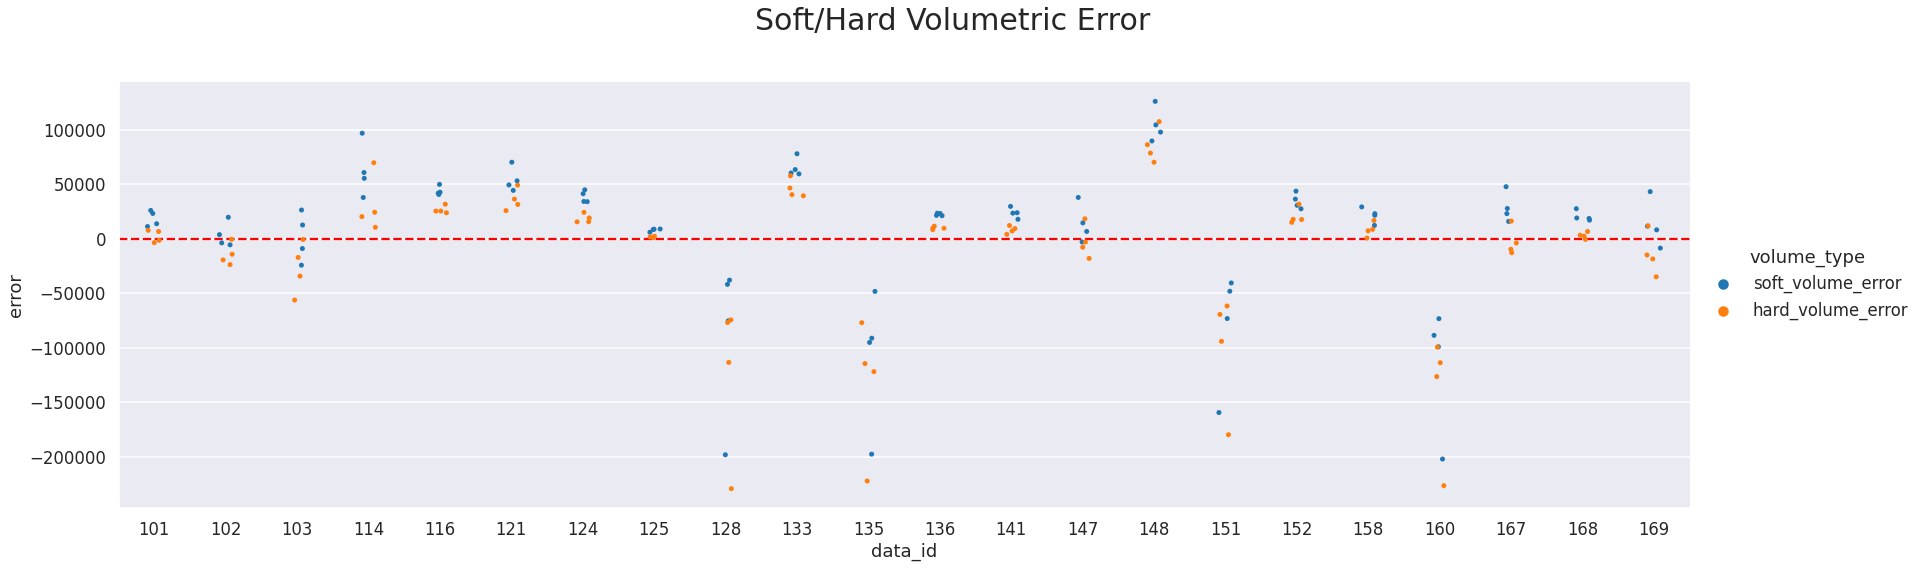

In [11]:
g = sns.catplot(
    exp_1_df,
    x="data_id",
    y="error",
    hue="volume_type",
    aspect=3,
    height=8,
    sharey=False,
)
# For each subplot make a line at y = 0 to show the error.
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='red')

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Soft/Hard Volumetric Error', fontsize=30)

# Show the plot
plt.show()

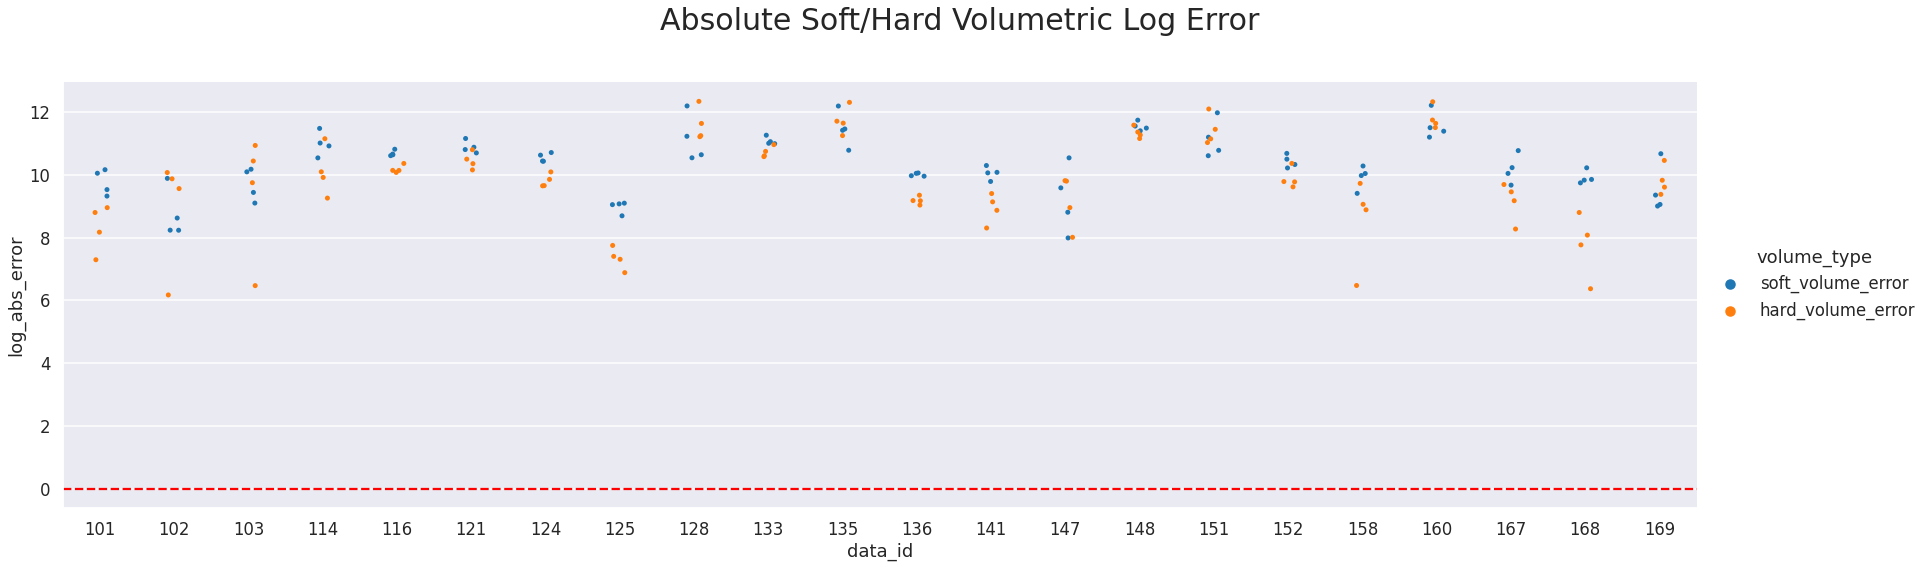

In [13]:
g = sns.catplot(
    exp_1_df,
    x="data_id",
    y="log_abs_error",
    hue="volume_type",
    aspect=3,
    height=8,
    sharey=False,
)
# For each subplot make a line at y = 0 to show the error.
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='red')

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Absolute Soft/Hard Volumetric Log Error', fontsize=30)

# Show the plot
plt.show()

# Experiment 2: Let's look at the same thing but this time also for Singapore.

In [14]:
exp_2_df = melted_error_df.select(annotator='observer_o12', task='Singapore')

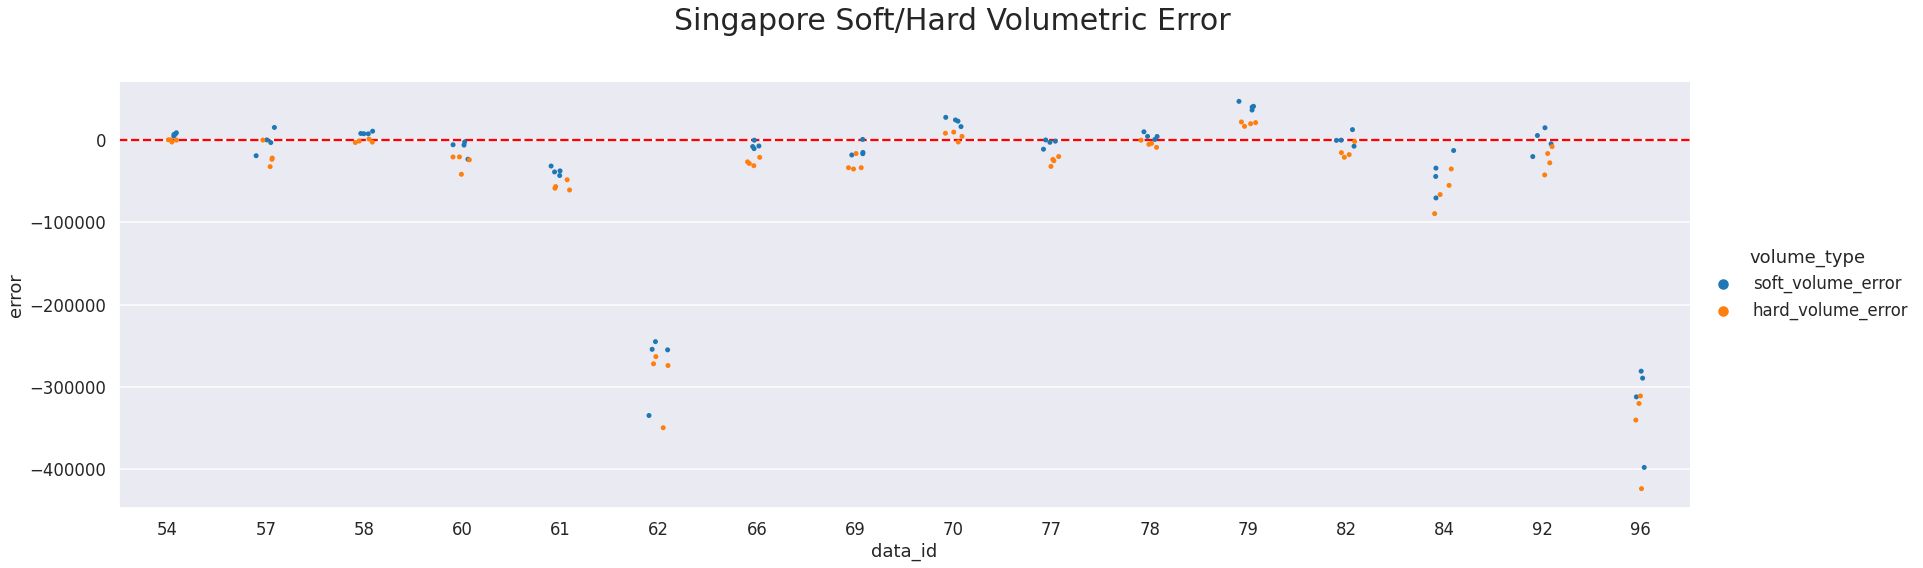

In [15]:
g = sns.catplot(
    exp_2_df,
    x="data_id",
    y="error",
    hue="volume_type",
    aspect=3,
    height=8,
    sharey=False,
)
# For each subplot make a line at y = 0 to show the error.
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='red')

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Singapore Soft/Hard Volumetric Error', fontsize=30)

# Show the plot
plt.show()

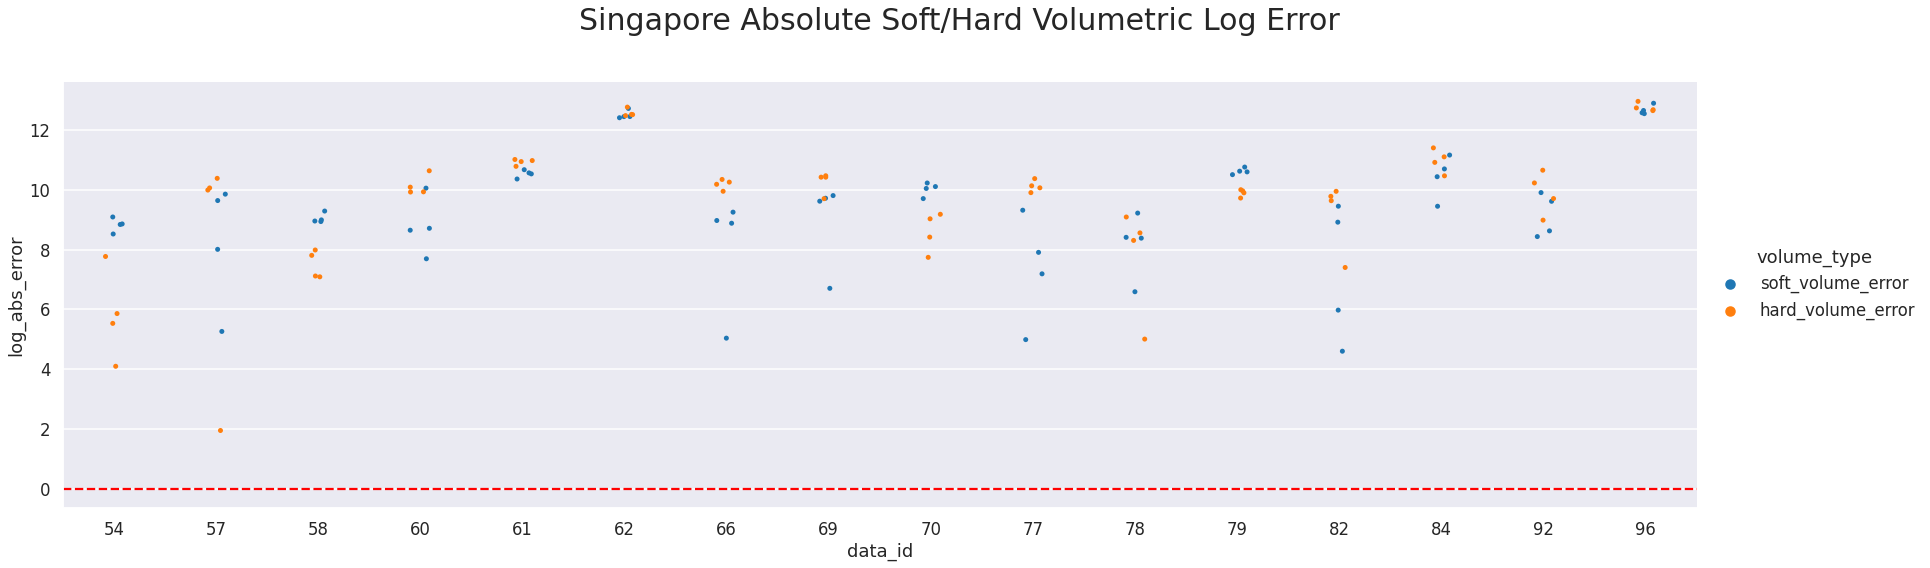

In [17]:
g = sns.catplot(
    exp_2_df,
    x="data_id",
    y="log_abs_error",
    hue="volume_type",
    aspect=3,
    height=8,
    sharey=False,
)
# For each subplot make a line at y = 0 to show the error.
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='red')

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Singapore Absolute Soft/Hard Volumetric Log Error', fontsize=30)

# Show the plot
plt.show()

# Experiment 3: The interesting thing about WMH is that we have multiple annotations per data_id (for some of the data_ids). Let's gather all of the data_ids that have all three annotators.

In [18]:
# Get the subset of the dataframe for which the number of unique annotators for each data_id is 3

# Step 1: Group by 'data_id' and count unique 'annotator' values
unique_counts = melted_error_df.groupby('data_id')['annotator'].nunique()
# Step 2: Filter 'data_id's that have exactly three unique 'annotator' values
filtered_data_ids = unique_counts[unique_counts == 3].index
# Step 3: Get the subset of rows with the filtered 'data_id's
multianno_melted_error_df= melted_error_df[melted_error_df['data_id'].isin(filtered_data_ids)]

In [19]:
multianno_melted_error_df['data_id'].unique().shape[0]

13

In [20]:
multianno_melted_error_df.select(data_id='101', pretrained_seed=40)

,annotator,data_id,pretrained_seed,task,gt_volume,soft_volume,hard_volume,volume_type,error,abs_error,log_abs_error
0,observer_o12,101,40,Amsterdam,44467,67689.760729,52222,soft_volume_error,23222.760729,23222.760729,10.052931
152,observer_o3,101,40,Amsterdam,26770,63007.674484,48819,soft_volume_error,36237.674484,36237.674484,10.497882
204,observer_o4,101,40,Amsterdam,57215,71583.688871,54436,soft_volume_error,14368.688871,14368.688871,9.572876
256,observer_o12,101,40,Amsterdam,44467,67689.760729,52222,hard_volume_error,7755.000000,7755.000000,8.956222
408,observer_o3,101,40,Amsterdam,26770,63007.674484,48819,hard_volume_error,22049.000000,22049.000000,10.001068
460,observer_o4,101,40,Amsterdam,57215,71583.688871,54436,hard_volume_error,-2779.000000,2779.000000,7.930206
